# Benchmark parallelismo

In questo notebook si vogliono evidenziare prestazioni e possibili criticità
del modello parallelo e della coda utilizzata per la comunicazione 
interprocesso, ossia `multiprocessing.Queue`.

## Comunicazione

La coda permette di implementare facilmente un paradigma produttore-consumatore,
usato per distribuire task a dei processi _worker_.

Essendo la comunicazione inter-processo, ogni oggetto inserito/rimosso 
nella/dalla coda viene serializzato/deserializzato tramite il modulo `pickle`.

Il benchmark è molto semplice: verranno inseriti (e rimossi) vari oggetti, di
diverse dimensioni nella (e dalla) coda. Lo stesso oggetto verrà inserito e
rimosso 100 volte. Saranno poi calcolati tempo medio e deviazione standard dei
tempi di inserimento e rimozione dalla coda.

Come oggetto da inviare utilizzeremo degli array `numpy`, i quali hanno una
dimensione ben definita, sia in termini di struttura, sia in termini di
attributi.


Di seguito verranno effettuati test utilizzando array di varie dimensioni.

In [2]:
dims = np.around(np.geomspace(10, 5242880 * 2, 21)).astype(int)
print(dims)

put_means = []
put_stds = []
get_means = []
get_stds = []

for d in dims:
    put_mean, put_std, get_mean, get_std = benchmark(d)
    print(f" put: ({put_mean:.5f}, {put_std:.5f})")
    print(f" get: ({get_mean:.5f}, {get_std:.5f})")

    put_means.append(put_mean)
    put_stds.append(put_std)

    get_means.append(get_mean)
    get_stds.append(get_std)


[      10       20       40       80      160      320      640     1280
     2560     5120    10240    20480    40960    81920   163840   327680
   655360  1310720  2621440  5242880 10485760]
dimension: 10, bytes: 80
 put: (0.00001, 0.00002)
 get: (0.00005, 0.00003)
dimension: 20, bytes: 160
 put: (0.00001, 0.00002)
 get: (0.00005, 0.00004)
dimension: 40, bytes: 320
 put: (0.00001, 0.00002)
 get: (0.00006, 0.00001)
dimension: 80, bytes: 640
 put: (0.00001, 0.00002)
 get: (0.00008, 0.00003)
dimension: 160, bytes: 1280
 put: (0.00002, 0.00005)
 get: (0.00013, 0.00005)
dimension: 320, bytes: 2560
 put: (0.00002, 0.00005)
 get: (0.00015, 0.00007)
dimension: 640, bytes: 5120
 put: (0.00002, 0.00005)
 get: (0.00014, 0.00004)
dimension: 1280, bytes: 10240
 put: (0.00002, 0.00005)
 get: (0.00013, 0.00009)
dimension: 2560, bytes: 20480
 put: (0.00002, 0.00004)
 get: (0.00017, 0.00006)
dimension: 5120, bytes: 40960
 put: (0.00002, 0.00004)
 get: (0.00022, 0.00008)
dimension: 10240, bytes: 81920

Abbiamo quindi esaminato una serie di possibili valori, da 80 byte a 40 MB.
Di seguito possiamo vedere graficamente come varia il tempo di inserimento e
rimozione dalla coda in funzione della dimensione degli oggetti inseriti.


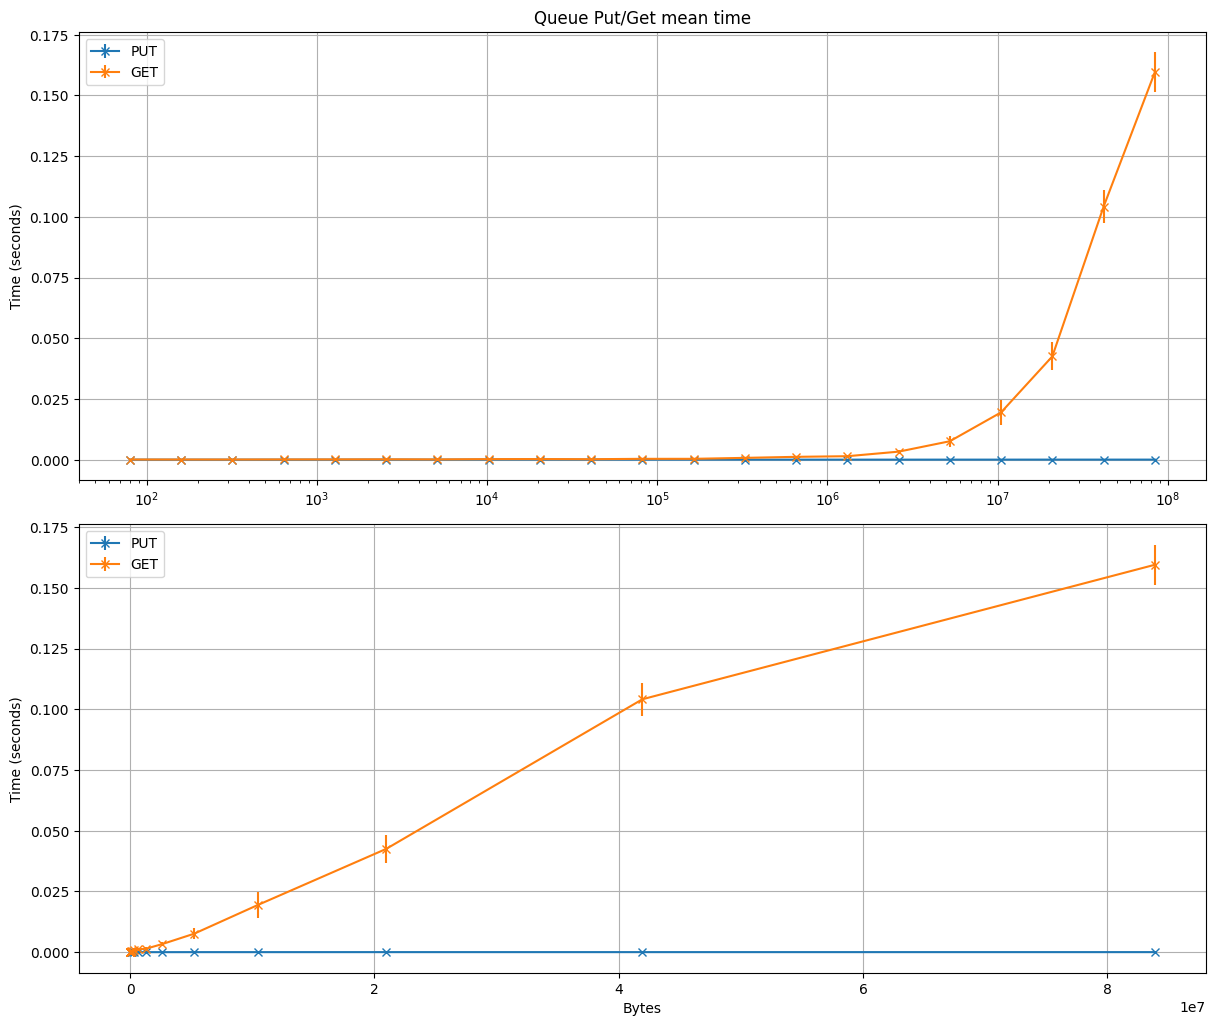

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plt.tight_layout()

# plt.figure(figsize=(16, 9))
ax1.set_title("Queue Put/Get mean time")
# ax1.set_xlabel("Bytes")
ax1.set_ylabel("Time (seconds)")

ax1.errorbar(dims * 8, put_means, put_stds, marker="x", label="PUT")
ax1.errorbar(dims * 8, get_means, get_stds, marker="x", label="GET")

ax1.legend()
ax1.set_xscale("log")
ax1.grid()

ax2.set_xlabel("Bytes")
ax2.set_ylabel("Time (seconds)")

ax2.errorbar(dims * 8, put_means, put_stds, marker="x", label="PUT")
ax2.errorbar(dims * 8, get_means, get_stds, marker="x", label="GET")

ax2.legend()
ax2.set_xscale("linear")
ax2.grid()

plt.show()

Come possiamo notare dal grafico, il costo dell'operazione di `put` rimane
praticamente costante, mentre quello dell'operazione di `get` tende a crescere
in modo stabile con il crescere della quantità di byte inviati.

Di seguito una semplice regressione lineare sui valori ottenuti per l'operazione
di `get`.


coefficiente angolare: 2.0099646784049436e-09


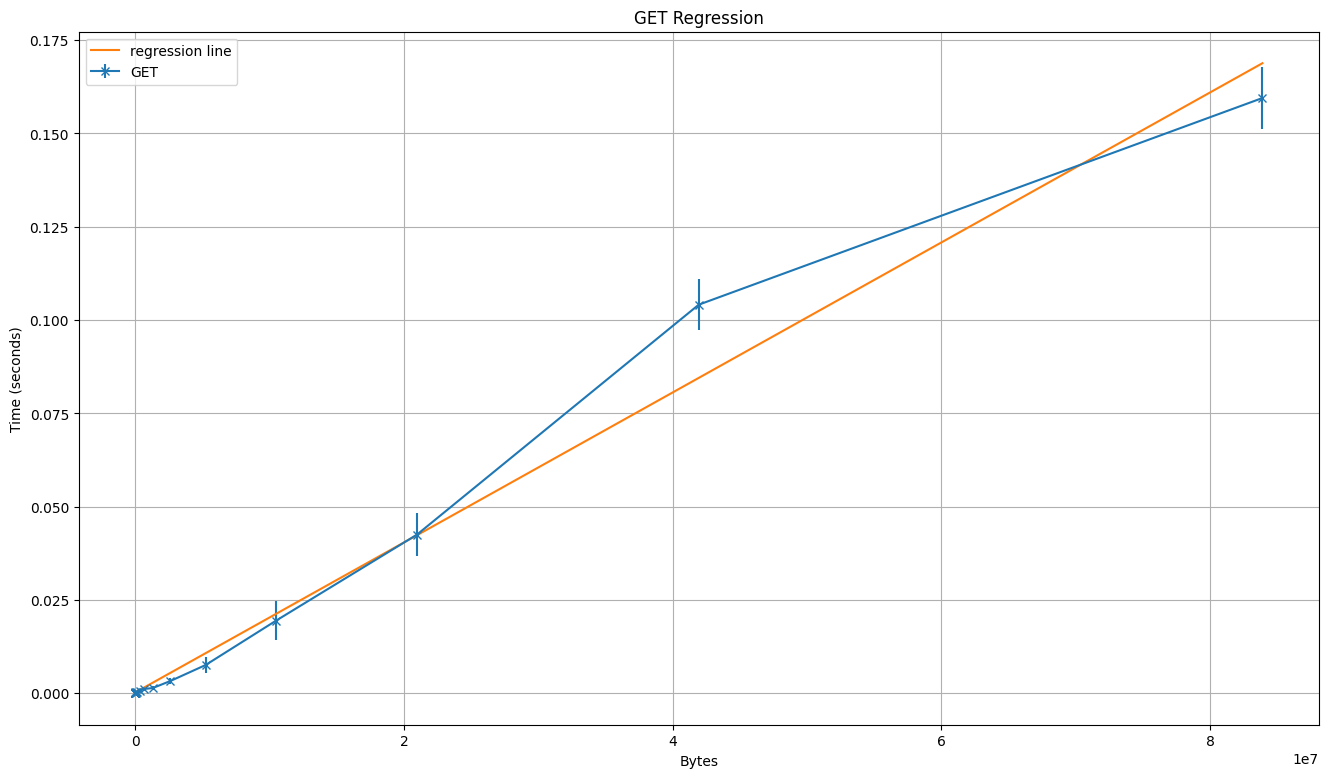

In [7]:
import statistics

slope, intercept = statistics.linear_regression(dims * 8, get_means)

print(f"coefficiente angolare: {slope}")

x = np.linspace(dims.min() * 8, dims.max() * 8, len(dims))
y = x * slope + intercept


plt.figure(figsize=(16, 9))
plt.title("GET Regression")
plt.xlabel("Bytes")
plt.ylabel("Time (seconds)")

plt.errorbar(dims * 8, get_means, get_stds, marker="x", label="GET")
plt.plot(x, y, label="regression line")

plt.legend()
plt.grid()
plt.show()

Come si può notare, il coefficiente angolare della retta di regressione è molto
basso. Ciò ci dice che il tempo dell'operazione di `get` cresce comunque molto
lentamente garantendo performance stabili anche per grandi quantità di dati.

Questo risultato ci suggerisce inoltre che sia più conveniente inviare più dati
possibile in blocco piuttosto che spezzarli in parti più piccole.

Analizziamo però la quantità di tempo necessaria per l'invio e la ricezione
dell'oggetto più piccolo, ossia quello da 80 byte.


In [7]:
print(f"{put_means[0] * 1000.0:.6f} millisecondi")
print(f"{get_means[0] * 1000.0:.6f} millisecondi")

0.006773 millisecondi
0.047299 millisecondi


Come possiamo vedere il tempo di inserimento è nell'ordine dei microsecondi,
mentre per la rimozione abbiamo un tempo medio nell'ordine dei centesimi di 
millisecondo.

Considerando il tempo di scheduling trascurabile, possiamo dire che il tempo
impiegato da un singolo worker in parallelo si compone in questo modo:

1. Tempo impiegato dal processo _Main_ per inserire i dati nella coda.
2. Tempo impiegato dal processo _Worker_ per estrarre i dati dalla coda.
3. Tempo di lavoro del worker.
4. Tempo impiegato dal worker per inserire i risultati nella coda.
5. Tempo impiegato dal processo _Main_ per estrarre i risultati dalla coda.

I passi 1, 2, 4 e 5 sono il tempo di sincronizzazione, metre il passo 3 è tempo
di lavoro. Affinché abbia senso usare un algoritmo parallelo è necessario che
il tempo di lavoro sia superiore al tempo di sincronizzazione.
